# Cytokine prediction

In this section, we try to predict the cytokines for an unseen TCB

In [1]:
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn.utils import shuffle
import skimage
plt.ion()   # interactive mode
from skimage.transform import   rescale, resize 
#from imageio import imread
import random
#import umap
from tqdm import tqdm
from random import sample
from skimage.transform import resize
import h5py
from skimage.exposure import rescale_intensity
import seaborn as sns
from umap import UMAP

2023-10-11 20:31:56.935437: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-11 20:31:56.937361: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-11 20:31:56.980379: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-11 20:31:56.981083: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 20:31:59.228415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
from skimage.util import crop

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

In [3]:
color_map = np.array([
 
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.8352941176470589, 0.3686274509803922, 0.0),
    (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8, 0.47058823529411764, 0.7372549019607844),
    (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2)])

lets load the data

In [4]:
metadata = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/metadata_subset_with_predictions.csv.gz")
metadata

file    experiment  \
0        /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
1        /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
2        /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
3        /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
4        /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_1   
...                                                    ...           ...   
1065962  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1065963  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1065964  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1065965  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   
1065966  /pstore/data/DS4/synapse_formation_full_data/E...  Experiment_4   

           donor condition  object_number        set label  \
0        Donor_1      +SEA           5156  unlabeled    -1   
1        Donor_1      +SEA          32020  unlabeled    -1   
2        Donor_1      +SEA          55974  unlabeled    -1   
3        Donor_1      +SEA          15150  unlabeled    -1   
4        Donor_1      +SEA          44814  unlabeled    -1   
...          ...       ...            ...        ...   ...   
1065962  Donor_9   DIG-TCB          72493  unlabeled    -1   
1065963  Donor_9   DIG-TCB         106656  unlabeled    -1   
1065964  Donor_9   DIG-TCB         110990  unlabeled    -1   
1065965  Donor_9   DIG-TCB          71451  unlabeled    -1   
1065966  Donor_9   DIG-TCB         111837  unlabeled    -1   

                     prediction   entropy                   key outlier  \
0                        B_cell  0.001350  Experiment_1 Donor_1   False   
1                        T_cell  0.000959  Experiment_1 Donor_1   False   
2                     Dead_Cell  0.002358  Experiment_1 Donor_1   False   
3                        T_cell  0.000502  Experiment_1 Donor_1   False   
4        B_cell_with_small_area  0.028317  Experiment_1 Donor_1   False   
...                         ...       ...                   ...     ...   
1065962   T_cell_with_signaling  0.259178  Experiment_4 Donor_9   False   
1065963                  B_cell  0.006382  Experiment_4 Donor_9   False   
1065964   T_cell_with_signaling  0.487638  Experiment_4 Donor_9   False   
1065965                  B_cell  0.082181  Experiment_4 Donor_9   False   
1065966                  T_cell  0.002511  Experiment_4 Donor_9   False   

         cluster  
0              0  
1              1  
2              0  
3              1  
4              2  
...          ...  
1065962        1  
1065963        0  
1065964        1  
1065965        2  
1065966        1  

[1065967 rows x 12 columns]

In [5]:
indx = metadata.outlier.astype(str) == "True"
metadata.loc[indx, "outlier"] = 1
metadata.loc[~indx, "outlier"] = 0
metadata["outlier"] = metadata["outlier"].astype(int)

In [6]:
metadata["file"] = metadata["file"].str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/")

In [7]:
metadata.head()

file    experiment    donor  \
0  /projects/site/pred/data_science/year/2022/imm...  Experiment_1  Donor_1   
1  /projects/site/pred/data_science/year/2022/imm...  Experiment_1  Donor_1   
2  /projects/site/pred/data_science/year/2022/imm...  Experiment_1  Donor_1   
3  /projects/site/pred/data_science/year/2022/imm...  Experiment_1  Donor_1   
4  /projects/site/pred/data_science/year/2022/imm...  Experiment_1  Donor_1   

  condition  object_number        set label              prediction   entropy  \
0      +SEA           5156  unlabeled    -1                  B_cell  0.001350   
1      +SEA          32020  unlabeled    -1                  T_cell  0.000959   
2      +SEA          55974  unlabeled    -1               Dead_Cell  0.002358   
3      +SEA          15150  unlabeled    -1                  T_cell  0.000502   
4      +SEA          44814  unlabeled    -1  B_cell_with_small_area  0.028317   

                    key  outlier  cluster  
0  Experiment_1 Donor_1        0        0  
1  Experiment_1 Donor_1        0        1  
2  Experiment_1 Donor_1        0        0  
3  Experiment_1 Donor_1        0        1  
4  Experiment_1 Donor_1        0        2

In [8]:

df_features = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/df_features_subset.csv.gz")
df_features

mask_based_area_BF  mask_based_bbox_area_BF  \
0                      2228                     3021   
1                       885                     1155   
2                       656                      812   
3                       753                      899   
4                      1208                     1512   
...                     ...                      ...   
1065962                 973                     1190   
1065963                3956                     5046   
1065964                 909                     1073   
1065965                3388                     4272   
1065966                 946                     1116   

         mask_based_convex_area_BF  mask_based_eccentricity_BF  \
0                             2392                    0.484394   
1                              925                    0.238094   
2                              689                    0.369856   
3                              780                    0.386491   
4                             1247                    0.661747   
...                            ...                         ...   
1065962                        997                    0.100885   
1065963                       4180                    0.787555   
1065964                        928                    0.622298   
1065965                       3670                    0.875994   
1065966                        969                    0.483446   

         mask_based_equivalent_diameter_BF  mask_based_euler_number_BF  \
0                                53.261409                           1   
1                                33.568095                           1   
2                                28.900608                           1   
3                                30.963678                           1   
4                                39.218279                           1   
...                                    ...                         ...   
1065962                          35.197473                           1   
1065963                          70.971372                           1   
1065964                          34.020211                           1   
1065965                          65.679035                           1   
1065966                          34.705686                           1   

         mask_based_extent_BF  mask_based_feret_diameter_max_BF  \
0                    0.737504                         61.717096   
1                    0.766234                         36.138622   
2                    0.807882                         32.756679   
3                    0.837597                         34.132096   
4                    0.798942                         51.224994   
...                       ...                               ...   
1065962              0.817647                         37.215588   
1065963              0.783987                         91.760558   
1065964              0.847158                         40.804412   
1065965              0.793071                         90.426766   
1065966              0.847670                         38.948684   

         mask_based_filled_area_BF  mask_based_major_axis_length_BF  ...  \
0                             2228                        57.336477  ...   
1                              885                        34.216438  ...   
2                              656                        30.262314  ...   
3                              753                        32.348559  ...   
4                             1208                        45.782110  ...   
...                            ...                              ...  ...   
1065962                        973                        35.332773  ...   
1065963                       3956                        91.437834  ...   
1065964                        909                        38.830446  ...   
1065965                       3388                        96.830707  ...   
1065966      

In [9]:
list_of_features_to_exclude = ["Antibody","Live-Dead","CD18",  "_R2",  "_R3",  "_R8", "background",
                               "moment","percent","mask_based_mean","mask_based_min","mask_based_max",  
                               "RMS","intensity_BF","_R1_R2","_R1_R3","_R1_R4","_R1_R5","_R1_R6","_R1_R7",
                               "_R1_R8","_R2_R1","_R2_R3","_R2_R4","_R2_R5","_R2_R6","_R2_R7","_R2_R8",
                               "_R3_R1","_R3_R2","_R3_R4","_R3_R5","_R3_R6","_R3_R7","_R3_R8",
                               "_R4_R1","_R4_R2","_R4_R3","_R4_R5","_R4_R6","_R4_R7","_R4_R8",
                               "_R5_R1","_R5_R2","_R5_R3","_R5_R4","_R5_R8","_R6_R1","_R6_R2",
                               "_R6_R3","_R6_R4","_R6_R5","_R6_R7","_R6_R8","_R7_R1","_R7_R2",
                               "_R7_R3","_R7_R4","_R7_R5","_R7_R6","_R7_R8","_R8_R1","_R8_R2",
                               "_R8_R3","_R8_R4","_R8_R5","_R8_R6","_R8_R7","cell_distance"]
classification_indx = ~df_features.columns.str.contains( list_of_features_to_exclude[0]) 

for f_to_exclude in list_of_features_to_exclude:
    classification_indx = classification_indx & ~df_features.columns.str.contains( f_to_exclude) 
    

print("list of remained columns:\n", 
      df_features.columns[classification_indx],
     "\n",
     "so we have these many columns:",
     classification_indx.sum())

list of remained columns:
 Index(['mask_based_area_BF', 'mask_based_bbox_area_BF',
       'mask_based_convex_area_BF', 'mask_based_eccentricity_BF',
       'mask_based_equivalent_diameter_BF', 'mask_based_euler_number_BF',
       'mask_based_extent_BF', 'mask_based_feret_diameter_max_BF',
       'mask_based_filled_area_BF', 'mask_based_major_axis_length_BF',
       ...
       'max_intensity_ratio_F-Actin_R5_R7', 'sum_intensity_ratio_MHCII_R5_R7',
       'mean_intensity_ratio_MHCII_R5_R7', 'max_intensity_ratio_MHCII_R5_R7',
       'sum_intensity_ratio_CD3_R5_R7', 'mean_intensity_ratio_CD3_R5_R7',
       'max_intensity_ratio_CD3_R5_R7', 'sum_intensity_ratio_P-CD3zeta_R5_R7',
       'mean_intensity_ratio_P-CD3zeta_R5_R7',
       'max_intensity_ratio_P-CD3zeta_R5_R7'],
      dtype='object', length=247) 
 so we have these many columns: 247


In [10]:
set_of_interesting_classes = ['B_cell',  'T_cell', 
                        'T_cell_with_signaling',
                        'B_T_cell_in_one_layer',
                        'Synapses_without_signaling', 
                        'Synapses_with_signaling',
                        'Multiplets'] 


we need to load the frequency data which was calculated previously

In [11]:
metadata_alive = pd.read_csv("/projects/site/pred/data_science/year/2022/immunological_synapse/synapse_data_features/metadata_alive_with_predictions.csv")

In [12]:
metadata_alive.head()

donor    experiment   condition  T_cell  T_cell_with_signaling  \
0  Donor_1  Experiment_1        +SEA   36.94                   7.92   
1  Donor_1  Experiment_1        -SEA   40.73                   7.77   
2  Donor_1  Experiment_1     Isotype   32.20                   8.65   
3  Donor_1  Experiment_1  Teplizumab   26.09                  11.92   
4  Donor_2  Experiment_1        +SEA   33.35                   7.18   

   B_T_cell_in_one_layer  Synapses_without_signaling  Synapses_with_signaling  \
0                   2.53                        2.92                     1.60   
1                   0.51                        0.65                     0.15   
2                   2.43                        2.86                     1.78   
3                   1.57                        2.13                     0.80   
4                   2.31                        2.12                     1.83   

   Multiplets  B_cell                   key  
0        3.48   44.62  Experiment_1 Donor_1  
1        0.59   49.62  Experiment_1 Donor_1  
2        5.23   46.84  Experiment_1 Donor_1  
3        2.85   54.64  Experiment_1 Donor_1  
4        2.91   50.29  Experiment_1 Donor_2

Finally, we need to add the cytokine values from flow cytometry

In [13]:
cytokine = pd.read_csv("cytokine_production.csv")


In [14]:
for i in range(len(cytokine)):
    if cytokine.loc[i,"condition"] == '"+SEA"':
        cytokine.loc[i,"condition"] = "+SEA"
    elif cytokine.loc[i,"condition"] == '"-SEA"':
        cytokine.loc[i,"condition"] = "-SEA"

In [15]:

cytokine = cytokine.loc[:,["donor",
                           "experiment",
                           "condition",
                           "TNFa", 
                           "GrzmB",
                           "IFNg",
                           "age",
                           "gender"]]
cytokine["TNFa"] = cytokine["TNFa"].fillna(-1.)
cytokine["GrzmB"] = cytokine["GrzmB"].fillna(-1.)
cytokine["IFNg"] = cytokine["IFNg"].fillna(-1.)
#cytokine["age"] = cytokine["age"].replace({'<30':"young",'30-50':"middle-age",'>50':"old" })

In [16]:
cytokine.head()

donor    experiment   condition   TNFa  GrzmB  IFNg  age gender
0  Donor_1  Experiment_1        +SEA  12.50   -1.0  -1.0  >50   male
1  Donor_1  Experiment_1        -SEA   0.33   -1.0  -1.0  >50   male
2  Donor_1  Experiment_1     Isotype  10.30   -1.0  -1.0  >50   male
3  Donor_1  Experiment_1   Abatacept   6.36   -1.0  -1.0  >50   male
4  Donor_1  Experiment_1  Teplizumab   5.83   -1.0  -1.0  >50   male

now lets merge the data

In [17]:
metadata_alive = pd.merge(metadata_alive, 
                             cytokine, 
                             how = "left", 
                             left_on=["donor","experiment","condition"],
                             right_on=["donor","experiment","condition"] )
metadata_alive = metadata_alive.dropna()

In [18]:
metadata_alive

donor    experiment   condition  T_cell  T_cell_with_signaling  \
0   Donor_1  Experiment_1        +SEA   36.94                   7.92   
1   Donor_1  Experiment_1        -SEA   40.73                   7.77   
2   Donor_1  Experiment_1     Isotype   32.20                   8.65   
3   Donor_1  Experiment_1  Teplizumab   26.09                  11.92   
4   Donor_2  Experiment_1        +SEA   33.35                   7.18   
5   Donor_2  Experiment_1        -SEA   38.47                   7.12   
6   Donor_2  Experiment_1     Isotype   30.60                   4.12   
7   Donor_2  Experiment_1  Teplizumab   19.06                  19.38   
8   Donor_3  Experiment_2        +SEA   11.43                  21.00   
9   Donor_3  Experiment_2        -SEA   15.20                  19.37   
10  Donor_3  Experiment_2     Isotype   13.51                  23.16   
11  Donor_3  Experiment_2  Teplizumab    3.86                  28.36   
12  Donor_4  Experiment_2        +SEA   16.13                  21.35   
13  Donor_4  Experiment_2        -SEA   17.05                  19.69   
14  Donor_4  Experiment_2     Isotype   15.95                  17.20   
15  Donor_4  Experiment_2  Teplizumab    2.54                  31.34   
16  Donor_1  Experiment_3        +SEA   24.56                  10.00   
17  Donor_1  Experiment_3        -SEA   20.62                  16.57   
18  Donor_1  Experiment_3     Isotype   26.02                   9.29   
19  Donor_1  Experiment_3  Teplizumab   22.27                  15.58   
20  Donor_1  Experiment_3    CD19-TCB   13.39                   5.05   
21  Donor_1  Experiment_3    CD20-TCB    5.52                   4.18   
22  Donor_1  Experiment_3     DIG-TCB   26.64                   8.88   
23  Donor_5  Experiment_3        +SEA   25.86                  11.50   
24  Donor_5  Experiment_3        -SEA   24.61                  12.43   
25  Donor_5  Experiment_3     Isotype   27.58                  11.65   
26  Donor_5  Experiment_3  Teplizumab   24.98                  14.08   
27  Donor_5  Experiment_3    CD19-TCB   11.21                   7.42   
28  Donor_5  Experiment_3    CD20-TCB    6.19                   5.42   
29  Donor_5  Experiment_3     DIG-TCB   32.41                   6.56   
30  Donor_6  Experiment_3        +SEA   17.12                   3.14   
31  Donor_6  Experiment_3        -SEA   17.36                   3.59   
32  Donor_6  Experiment_3     Isotype   15.55                   1.71   
33  Donor_6  Experiment_3  Teplizumab   13.80                   2.78   
34  Donor_2  Experiment_4        -SEA   33.43                  22.60   
35  Donor_2  Experiment_4    CD19-TCB   24.01                  18.81   
36  Donor_2  Experiment_4    CD20-TCB   25.91                  16.33   
37  Donor_2  Experiment_4     DIG-TCB   29.17                  24.55   
38  Donor_7  Experiment_4        +SEA   21.77                  15.33   
39  Donor_7  Experiment_4        -SEA   29.37                  13.89   
40  Donor_7  Experiment_4    CD19-TCB   18.16                  13.94   
41  Donor_7  Experiment_4    CD20-TCB   14.75                   7.59   
42  Donor_7  Experiment_4     DIG-TCB   28.87                  14.85   
43  Donor_8  Experiment_4        +SEA   29.20                  28.53   
44  Donor_8  Experiment_4        -SEA   30.78                  15.38   
45  Donor_8  Experiment_4    CD19-TCB   22.65                  12.88   
46  Donor_8  Experiment_4    CD20-TCB   27.27                   8.80   
47  Donor_8  Experiment_4     DIG-TCB   31.82                  17.90   
48  Donor_9  Experiment_4        +SEA   25.92                  14.62   
49  Donor_9  Experiment_4        -SEA   29.93                  15.16   
50  Donor_9  Experiment_4    CD19-TCB   14.77                  11.82   
51  Donor_9  Experiment_4    CD20-TCB   17.49                   9.43   
52  Donor_9  Experiment_4     DIG-TCB   27.17                  16.38   

    B_T_cell_in_one_layer  Synapses_without_signaling  \
0                    2.53                        2.92   
1  

lets clean the values

In [19]:

#metadata_alive.iloc[:,5:-2] =metadata_alive.iloc[:,5:-2].astype(float)
metadata_alive.iloc[:,3:-6] =metadata_alive.iloc[:,3:-6].astype(float)
metadata_alive["TNFa"] = metadata_alive["TNFa"].astype(float)
metadata_alive["GrzmB"] = metadata_alive["GrzmB"].astype(float)
metadata_alive["IFNg"] = metadata_alive["IFNg"].astype(float)

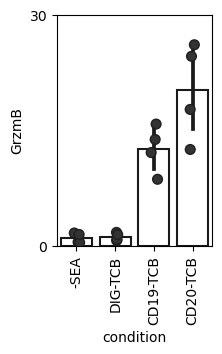

In [20]:
fig , ax = plt.subplots(1, figsize = (0.5*4,3) )

indx = metadata_alive["experiment"] == "Experiment_4"

ax = sns.barplot(data = metadata_alive.loc[indx,:] , 
                       x = "condition",
                       y = "GrzmB", 
                       order = [ "-SEA",'DIG-TCB', 'CD19-TCB', 'CD20-TCB'], 
                     linewidth=1.5, facecolor=(1, 1, 1, 0),
                     errcolor=".1", edgecolor=".1",
                ax=ax) 


ax = sns.stripplot(data = metadata_alive.loc[indx,:] , 
                       x = "condition",
                       y = "GrzmB", 
                       hue = "experiment", 
                       order = ["-SEA",'DIG-TCB', 'CD19-TCB', 'CD20-TCB'],
                       hue_order = [
                                    "Exp_1",
                                    "Exp_2",
                                    "Exp_3",
                                    "Experiment_4"],
                       s = 7,
                       linewidth=1,
                       #split = True,
                      palette=np.array([(1,1,1 ),
                                        (0.85, 0.85, 0.85 ),
                                        (0.60, 0.60, 0.60 ),
                                        (0.2,0.2,0.2 )]), 
                       dodge=False,
                      ax = ax) 


ax.legend().remove()
ax.set_xticklabels(["-SEA",'DIG-TCB', 'CD19-TCB', 'CD20-TCB'], rotation = "vertical")
ax.set_yticks([0, 30]   )
ax.set_ylim(0,30 )

plt.savefig('Figure - GrzmB frequencies - experiment four.png', bbox_inches="tight")
plt.savefig('Figure - GrzmB frequencies - experiment four.svg', bbox_inches="tight")

In [21]:
indx = metadata["prediction"].isin(["Synapses_without_signaling","Synapses_with_signaling"])#
indx = metadata["outlier"].isin([0])#

columns_of_interest = classification_indx & (~df_features.columns.str.contains("BF"))

# Feature aggregation

Here we aggregate the features using 5th, 50th and 95th percentile

In [22]:
indx = metadata["prediction"].isin(["Synapses_without_signaling","Synapses_with_signaling"])#
indx = metadata["outlier"].isin([0])#

columns_of_interest = classification_indx & (~df_features.columns.str.contains("BF"))


percentile_05_values = pd.concat([metadata.loc[indx,["donor","experiment","condition"]], 
                           df_features.loc[indx,columns_of_interest]], 
                          axis = 1).groupby(["donor","experiment","condition"]).quantile(0.05).reset_index()
percentile_05_values = percentile_05_values.loc[:, ["donor","experiment","condition"] +   (percentile_05_values.iloc[:,3:].std() > 0.).index.tolist()]

percentile_50_values = pd.concat([metadata.loc[indx,["donor","experiment","condition"]], 
                           df_features.loc[indx,columns_of_interest]], 
                          axis = 1).groupby(["donor","experiment","condition"]).quantile(0.50).reset_index()
percentile_50_values = percentile_50_values.loc[:, ["donor","experiment","condition"] +   (percentile_50_values.iloc[:,3:].std() > 0.).index.tolist()]


percentile_95_values = pd.concat([metadata.loc[indx,["donor","experiment","condition"]], 
                           df_features.loc[indx,columns_of_interest]],  
                          axis = 1).groupby(["donor","experiment","condition"]).quantile(0.95).reset_index()
percentile_95_values = percentile_95_values.loc[:, ["donor","experiment","condition"] +   (percentile_95_values.iloc[:,3:].std() > 0.).index.tolist()]



In [23]:
percentile_05_values_names = dict()
for col in percentile_05_values.columns.values[3:]:
    percentile_05_values_names[col] = col + "_05"
percentile_05_values = percentile_05_values.rename(columns=percentile_05_values_names)

percentile_50_values_names = dict()
for col in percentile_50_values.columns.values[3:]:
    percentile_50_values_names[col] = col + "_50"
percentile_50_values = percentile_50_values.rename(columns=percentile_50_values_names)


percentile_95_values_names = dict()
for col in percentile_95_values.columns.values[3:]:
    percentile_95_values_names[col] = col + "_95"
percentile_95_values = percentile_95_values.rename(columns=percentile_95_values_names)

In [24]:
metadata_alive = pd.merge(metadata_alive, 
                             percentile_05_values, 
                             how = "left", 
                             left_on=["donor","experiment", "condition"],
                             right_on=["donor","experiment", "condition"] )

metadata_alive = pd.merge(metadata_alive, 
                             percentile_50_values, 
                             how = "left", 
                             left_on=["donor","experiment", "condition"],
                             right_on=["donor","experiment", "condition"] )

metadata_alive = pd.merge(metadata_alive, 
                             percentile_95_values, 
                             how = "left", 
                             left_on=["donor","experiment", "condition"],
                             right_on=["donor","experiment", "condition"] )

In [25]:
metadata_alive

donor    experiment   condition  T_cell  T_cell_with_signaling  \
0   Donor_1  Experiment_1        +SEA   36.94                   7.92   
1   Donor_1  Experiment_1        -SEA   40.73                   7.77   
2   Donor_1  Experiment_1     Isotype   32.20                   8.65   
3   Donor_1  Experiment_1  Teplizumab   26.09                  11.92   
4   Donor_2  Experiment_1        +SEA   33.35                   7.18   
5   Donor_2  Experiment_1        -SEA   38.47                   7.12   
6   Donor_2  Experiment_1     Isotype   30.60                   4.12   
7   Donor_2  Experiment_1  Teplizumab   19.06                  19.38   
8   Donor_3  Experiment_2        +SEA   11.43                  21.00   
9   Donor_3  Experiment_2        -SEA   15.20                  19.37   
10  Donor_3  Experiment_2     Isotype   13.51                  23.16   
11  Donor_3  Experiment_2  Teplizumab    3.86                  28.36   
12  Donor_4  Experiment_2        +SEA   16.13                  21.35   
13  Donor_4  Experiment_2        -SEA   17.05                  19.69   
14  Donor_4  Experiment_2     Isotype   15.95                  17.20   
15  Donor_4  Experiment_2  Teplizumab    2.54                  31.34   
16  Donor_1  Experiment_3        +SEA   24.56                  10.00   
17  Donor_1  Experiment_3        -SEA   20.62                  16.57   
18  Donor_1  Experiment_3     Isotype   26.02                   9.29   
19  Donor_1  Experiment_3  Teplizumab   22.27                  15.58   
20  Donor_1  Experiment_3    CD19-TCB   13.39                   5.05   
21  Donor_1  Experiment_3    CD20-TCB    5.52                   4.18   
22  Donor_1  Experiment_3     DIG-TCB   26.64                   8.88   
23  Donor_5  Experiment_3        +SEA   25.86                  11.50   
24  Donor_5  Experiment_3        -SEA   24.61                  12.43   
25  Donor_5  Experiment_3     Isotype   27.58                  11.65   
26  Donor_5  Experiment_3  Teplizumab   24.98                  14.08   
27  Donor_5  Experiment_3    CD19-TCB   11.21                   7.42   
28  Donor_5  Experiment_3    CD20-TCB    6.19                   5.42   
29  Donor_5  Experiment_3     DIG-TCB   32.41                   6.56   
30  Donor_6  Experiment_3        +SEA   17.12                   3.14   
31  Donor_6  Experiment_3        -SEA   17.36                   3.59   
32  Donor_6  Experiment_3     Isotype   15.55                   1.71   
33  Donor_6  Experiment_3  Teplizumab   13.80                   2.78   
34  Donor_2  Experiment_4        -SEA   33.43                  22.60   
35  Donor_2  Experiment_4    CD19-TCB   24.01                  18.81   
36  Donor_2  Experiment_4    CD20-TCB   25.91                  16.33   
37  Donor_2  Experiment_4     DIG-TCB   29.17                  24.55   
38  Donor_7  Experiment_4        +SEA   21.77                  15.33   
39  Donor_7  Experiment_4        -SEA   29.37                  13.89   
40  Donor_7  Experiment_4    CD19-TCB   18.16                  13.94   
41  Donor_7  Experiment_4    CD20-TCB   14.75                   7.59   
42  Donor_7  Experiment_4     DIG-TCB   28.87                  14.85   
43  Donor_8  Experiment_4        +SEA   29.20                  28.53   
44  Donor_8  Experiment_4        -SEA   30.78                  15.38   
45  Donor_8  Experiment_4    CD19-TCB   22.65                  12.88   
46  Donor_8  Experiment_4    CD20-TCB   27.27                   8.80   
47  Donor_8  Experiment_4     DIG-TCB   31.82                  17.90   
48  Donor_9  Experiment_4        +SEA   25.92                  14.62   
49  Donor_9  Experiment_4        -SEA   29.93                  15.16   
50  Donor_9  Experiment_4    CD19-TCB   14.77                  11.82   
51  Donor_9  Experiment_4    CD20-TCB   17.49                   9.43   
52  Donor_9  Experiment_4     DIG-TCB   27.17                  16.38   

    B_T_cell_in_one_layer  Synapses_without_signaling  \
0                    2.53                        2.92   
1  

# CD19-TCB and CD20-TCB prediction

In this part, we use a preselected features based on the biology and using Lasso Lars, we predict the cytokines

In [26]:

general_cols = []
general_cols += [
    
    "mean_intensity_ratio_F-Actin_R5_R6", 
    "mean_intensity_ratio_MHCII_R5_R6", 
    "mean_intensity_ratio_P-CD3zeta_R5_R6",
    
    "dissimilarity_F-Actin",
    "dissimilarity_MHCII",
    "dissimilarity_P-CD3zeta",
    
    'correlation_F-Actin',
    'correlation_MHCII',
    'correlation_P-CD3zeta',
    
    'mask_based_solidity_F-Actin',
    'mask_based_solidity_MHCII',
    'mask_based_solidity_P-CD3zeta',
    
    "mask_based_eccentricity_F-Actin",
    "mask_based_eccentricity_MHCII",
    "mask_based_eccentricity_P-CD3zeta",   
    
    'mean_intensity_F-Actin',
    'mean_intensity_MHCII',
    'mean_intensity_P-CD3zeta',
    
    'std_intensity_F-Actin',
    'std_intensity_MHCII',
    'std_intensity_P-CD3zeta',
]    


general_cols = set(general_cols)
general_cols = list(general_cols)
 

cols_ = []
for gc in general_cols:
    
    cols_ += [gc + "_05"]
    cols_ += [gc + "_50"]
    cols_ += [gc + "_95"]
    
    
cols_ = set(cols_)
cols_ = list(cols_)


In [27]:
from sklearn.metrics import fbeta_score, make_scorer, mean_squared_log_error, mean_squared_error, r2_score
from scipy.stats import spearmanr, pearsonr

def scorr_logloss(ground_truth, predictions):
    
    s_corr = spearmanr(ground_truth,predictions)
    r2 = r2_score(ground_truth,predictions)
    logloss = mean_squared_log_error(ground_truth,predictions)
    
    return s_corr[0] + 0.8*r2 - logloss

In [28]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import (Lasso, 
                                  LassoCV, 
                                  ElasticNet,
                                  ElasticNetCV, 
                                  RidgeCV, 
                                  Ridge, 
                                  LassoLarsIC, 
                                  LassoLarsCV, 
                                  LinearRegression,
                                  HuberRegressor, 
                                  LassoLars)
from sklearn.linear_model import (
    LinearRegression,
    TheilSenRegressor,
    RANSACRegressor,
    HuberRegressor,
)
from sklearn.linear_model import PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneGroupOut, cross_validate, cross_val_predict
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.feature_selection import f_regression, f_classif, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_log_error

preds = []
most_important_features = dict()
for cond in ['CD19-TCB','CD20-TCB']:
    train_conds  = ["-SEA", 'DIG-TCB', 'CD19-TCB','CD20-TCB']
    train_conds.remove(cond)
    
    train_indx = metadata_alive["condition"].isin(train_conds)
    train_indx = train_indx & metadata_alive["experiment"].isin(["Experiment_4"])     
    train_indx = train_indx[train_indx].index
    print("train", train_conds, len(train_indx))

    
    test_indx = metadata_alive["condition"].isin([cond])
    test_indx = test_indx & metadata_alive["experiment"].isin(["Experiment_4"])
    print("test", [cond], test_indx.sum())  
    
 
    lm_GrzmB =  Pipeline([ 
            ("VarianceThreshold", VarianceThreshold(0.)), 
            ("StandardScaler", StandardScaler()),
            ('LassoLars',  TransformedTargetRegressor(regressor =LassoLars(random_state=3), # 
                                                     transformer=StandardScaler()))
    ]) 
    

    parameters = {
                  'LassoLars__regressor__alpha': np.linspace(1e-16,7,100), 
                  'LassoLars__regressor__jitter':np.linspace(-1.,1.,20), 
                  'LassoLars__regressor__fit_intercept':[True,False], 
                 }
    
    lm_GrzmB = GridSearchCV(lm_GrzmB, 
                           parameters, 
                           n_jobs = -1, 
                           cv = LeaveOneGroupOut(),
                           refit=True,
                           verbose = 0,
                          scoring=make_scorer(scorr_logloss, greater_is_better=True),
                          )
    
    lm_GrzmB = lm_GrzmB.fit(metadata_alive.loc[train_indx, cols_ ].to_numpy(), 
                metadata_alive.loc[train_indx, "GrzmB"].to_numpy(),
                         groups = metadata_alive.loc[train_indx, "donor"].to_numpy()
                         )    
    print(lm_GrzmB.best_params_)
    print("____________________________")
    selected_features = np.array(cols_)[lm_GrzmB.best_estimator_.steps[0][-1].get_support()]
    most_important_features[cond] = dict()
    for i, selected_f in enumerate(selected_features):
        coef_value = lm_GrzmB.best_estimator_.steps[-1][1].regressor_.coef_[i]
        if  coef_value!= 0.:
            most_important_features[cond][selected_f] = coef_value 
    
    for k in range(test_indx.sum()):
        preds.append([metadata_alive.loc[test_indx, "GrzmB"].tolist()[k] ,  
                 lm_GrzmB.predict(metadata_alive.loc[test_indx, cols_].to_numpy())[k], 
                     metadata_alive.loc[test_indx, "condition"].tolist()[k] , 
                     metadata_alive.loc[test_indx, "donor"].tolist()[k], 
                     metadata_alive.loc[test_indx, "experiment"].tolist()[k]]  ) 
        
#ax[-1,1].set_ylim([-0.1,1.5])

train ['-SEA', 'DIG-TCB', 'CD20-TCB'] 12
test ['CD19-TCB'] 4


/home/shetabs1/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/shetabs1/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shetabs1/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shetabs1/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'LassoLars__regressor__alpha': 0.5656565656565657, 'LassoLars__regressor__fit_intercept': False, 'LassoLars__regressor__jitter': 0.05263157894736836}
____________________________
train ['-SEA', 'DIG-TCB', 'CD19-TCB'] 12
test ['CD20-TCB'] 4


/home/shetabs1/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/shetabs1/.local/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shetabs1/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/shetabs1/.local/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'LassoLars__regressor__alpha': 0.0707070707070708, 'LassoLars__regressor__fit_intercept': False, 'LassoLars__regressor__jitter': 0.05263157894736836}
____________________________


/home/shetabs1/.local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/shetabs1/.local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/shetabs1/.local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/shetabs1/.local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/home/shetabs1/.local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445

In [29]:
preds = pd.DataFrame(preds, columns=["GrzmB", "GrzmB_preds","condition","donor","experiment"])

preds

GrzmB  GrzmB_preds condition    donor    experiment
0   8.63     7.875707  CD19-TCB  Donor_2  Experiment_4
1  13.80     7.008906  CD19-TCB  Donor_7  Experiment_4
2  15.80     7.992735  CD19-TCB  Donor_8  Experiment_4
3  12.10     8.962902  CD19-TCB  Donor_9  Experiment_4
4  26.10    11.250794  CD20-TCB  Donor_2  Experiment_4
5  12.50    20.696527  CD20-TCB  Donor_7  Experiment_4
6  24.60    16.164749  CD20-TCB  Donor_8  Experiment_4
7  17.70    12.260316  CD20-TCB  Donor_9  Experiment_4

In [30]:
print( "MSE", round( mean_squared_error(preds["GrzmB"],preds["GrzmB_preds"]),2)   )


MSE 63.24


In [31]:
print( "MSLE", round( mean_squared_log_error(preds["GrzmB"],preds["GrzmB_preds"]),2)   )


MSLE 0.25


In [32]:
print( "r2_score", round( r2_score(preds["GrzmB"],preds["GrzmB_preds"]),2)   )

r2_score -0.91


In [33]:
print("Spearamn corr", round(spearmanr(preds["GrzmB"],preds["GrzmB_preds"])[0],2)   )

Spearamn corr 0.38


In [34]:
print("Pearson corr", round(pearsonr(preds["GrzmB"],preds["GrzmB_preds"])[0],2))

Pearson corr 0.26


In [35]:
lm_GrzmB.best_params_

{'LassoLars__regressor__alpha': 0.0707070707070708,
 'LassoLars__regressor__fit_intercept': False,
 'LassoLars__regressor__jitter': 0.05263157894736836}

In [36]:
most_important_features

{'CD19-TCB': {'correlation_F-Actin_05': -0.24368885642548033,
  'mask_based_solidity_F-Actin_50': -0.15746702910985116},
 'CD20-TCB': {'mean_intensity_ratio_P-CD3zeta_R5_R6_95': 0.1521071406552637,
  'mask_based_eccentricity_F-Actin_95': 0.050502642249746967,
  'std_intensity_F-Actin_05': -0.17213279666709286,
  'dissimilarity_P-CD3zeta_05': -0.6122747569323039}}

In [37]:
pd.DataFrame(preds)

GrzmB  GrzmB_preds condition    donor    experiment
0   8.63     7.875707  CD19-TCB  Donor_2  Experiment_4
1  13.80     7.008906  CD19-TCB  Donor_7  Experiment_4
2  15.80     7.992735  CD19-TCB  Donor_8  Experiment_4
3  12.10     8.962902  CD19-TCB  Donor_9  Experiment_4
4  26.10    11.250794  CD20-TCB  Donor_2  Experiment_4
5  12.50    20.696527  CD20-TCB  Donor_7  Experiment_4
6  24.60    16.164749  CD20-TCB  Donor_8  Experiment_4
7  17.70    12.260316  CD20-TCB  Donor_9  Experiment_4

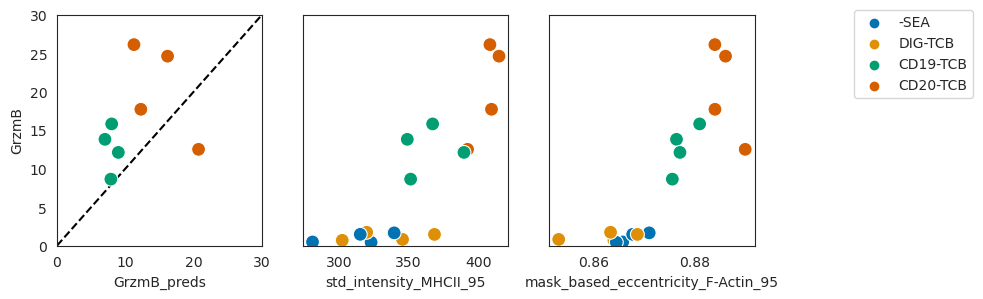

In [38]:
sns.set_style("white")
fig, ax = plt.subplots(ncols = 3,figsize = (9,3), sharey = True)

ax[0].axline([0.5, 0.5], [0.8, 0.8], c = "k",  ls = "--")
ax[0] = sns.scatterplot(data = pd.DataFrame(preds),
    x = "GrzmB_preds" ,
              y ="GrzmB", 
                     s = 100,
                     hue = "condition", 
                     hue_order = ["-SEA",'DIG-TCB',"CD19-TCB","CD20-TCB"],
                     palette = sns.color_palette("colorblind"),
                     ax = ax[0], 
                     zorder = 10
                    )
ax[0].legend(bbox_to_anchor=(1.1, 1.05)).remove()
ax[0].set_xlim(0,30)
ax[0].set_ylim(0,30)


row_index  = ["-SEA",'DIG-TCB', 'CD19-TCB','CD20-TCB']
    
row_index = metadata_alive["condition"].isin(row_index)
row_index = row_index & metadata_alive["experiment"].isin(["Experiment_4"])     

ax[1] = sns.scatterplot(data = metadata_alive.loc[row_index,:],
    x = "std_intensity_MHCII_95" ,
              y ="GrzmB", 
                     s = 100,
                     hue = "condition", 
                     hue_order = ["-SEA",'DIG-TCB', 'CD19-TCB','CD20-TCB'],
                     palette = sns.color_palette("colorblind"),
                     ax = ax[1], 
                     zorder = 10
                    )
ax[1].legend(bbox_to_anchor=(2.1, 1.05)).remove()
#ax[1].set_xlim(250,500)
ax[1].set_ylim(0,30)

ax[2] = sns.scatterplot(data = metadata_alive.loc[row_index,:],
    x = 'mask_based_eccentricity_F-Actin_95' ,
              y ="GrzmB", 
                     s = 100,
                     hue = "condition", 
                     hue_order = ["-SEA",'DIG-TCB', 'CD19-TCB','CD20-TCB'],
                     palette = sns.color_palette("colorblind"),
                     ax = ax[2], 
                     zorder = 10
                    )
ax[2].legend(bbox_to_anchor=(2.1, 1.05))
#ax[1].set_xlim(250,500)
ax[2].set_ylim(0,30)

plt.savefig('Figure5 - CD20 CD19 GrmzB.png', bbox_inches="tight")
plt.savefig('Figure5 - CD20 CD19 GrmzB.svg', bbox_inches="tight")

In [39]:
pd.DataFrame(preds)[["GrzmB"	,"GrzmB_preds"]].corr("spearman")

GrzmB  GrzmB_preds
GrzmB        1.000000     0.380952
GrzmB_preds  0.380952     1.000000

In [40]:

metadata_alive.loc[row_index,["std_intensity_MHCII_95", 'mask_based_eccentricity_F-Actin_95',
 'GrzmB']].corr("spearman").round(2)

std_intensity_MHCII_95  \
std_intensity_MHCII_95                                1.00   
mask_based_eccentricity_F-Actin_95                    0.84   
GrzmB                                                 0.81   

                                    mask_based_eccentricity_F-Actin_95  GrzmB  
std_intensity_MHCII_95                                            0.84   0.81  
mask_based_eccentricity_F-Actin_95                                1.00   0.84  
GrzmB                                                             0.84   1.00

In [41]:
pd.DataFrame(preds).to_csv("Source Data Figure 4d.csv", index=False)

In [42]:
metadata_alive.loc[row_index,['donor', 'experiment', 'condition', "GrzmB", "std_intensity_MHCII_95", 'mask_based_eccentricity_F-Actin_95']].to_csv("Source Data Figure 4e-f.csv", index=False)

0.6764705882352942


<Axes: xlabel='std_intensity_MHCII_95', ylabel='mean_intensity_ratio_P-CD3zeta_R5_R6_95'>

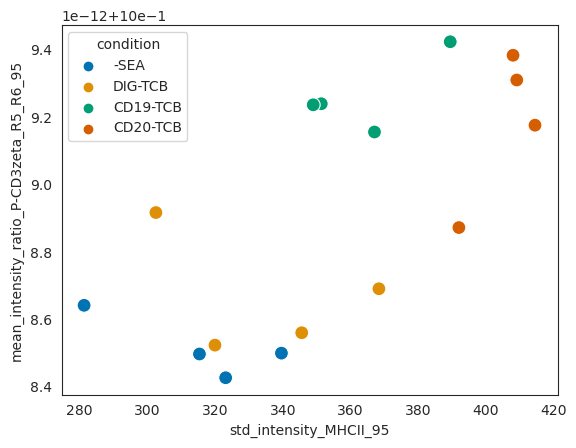

In [43]:
row_index  = ["-SEA",'DIG-TCB', 'CD19-TCB','CD20-TCB']
    
row_index = metadata_alive["condition"].isin(row_index)
row_index = row_index & metadata_alive["experiment"].isin(["Experiment_4"])     

cols = ["std_intensity_MHCII_95", 'mean_intensity_ratio_P-CD3zeta_R5_R6_95']
print(metadata_alive.loc[row_index,cols].corr("spearman").iloc[0,1] )
sns.scatterplot(data = metadata_alive.loc[row_index,:],
    x =  cols[0],
              y =cols[1], 
                     s = 100,
                     hue = "condition", 
                     hue_order = ["-SEA",'DIG-TCB', 'CD19-TCB','CD20-TCB'],
                     palette = sns.color_palette("colorblind"),
                     zorder = 10
                    )
 

In [44]:
metadata_alive.loc[row_index,["donor","condition","GrzmB"]]

donor condition  GrzmB
34  Donor_2      -SEA   0.47
35  Donor_2  CD19-TCB   8.63
36  Donor_2  CD20-TCB  26.10
37  Donor_2   DIG-TCB   0.68
39  Donor_7      -SEA   0.42
40  Donor_7  CD19-TCB  13.80
41  Donor_7  CD20-TCB  12.50
42  Donor_7   DIG-TCB   0.80
44  Donor_8      -SEA   1.65
45  Donor_8  CD19-TCB  15.80
46  Donor_8  CD20-TCB  24.60
47  Donor_8   DIG-TCB   1.73
49  Donor_9      -SEA   1.46
50  Donor_9  CD19-TCB  12.10
51  Donor_9  CD20-TCB  17.70
52  Donor_9   DIG-TCB   1.45

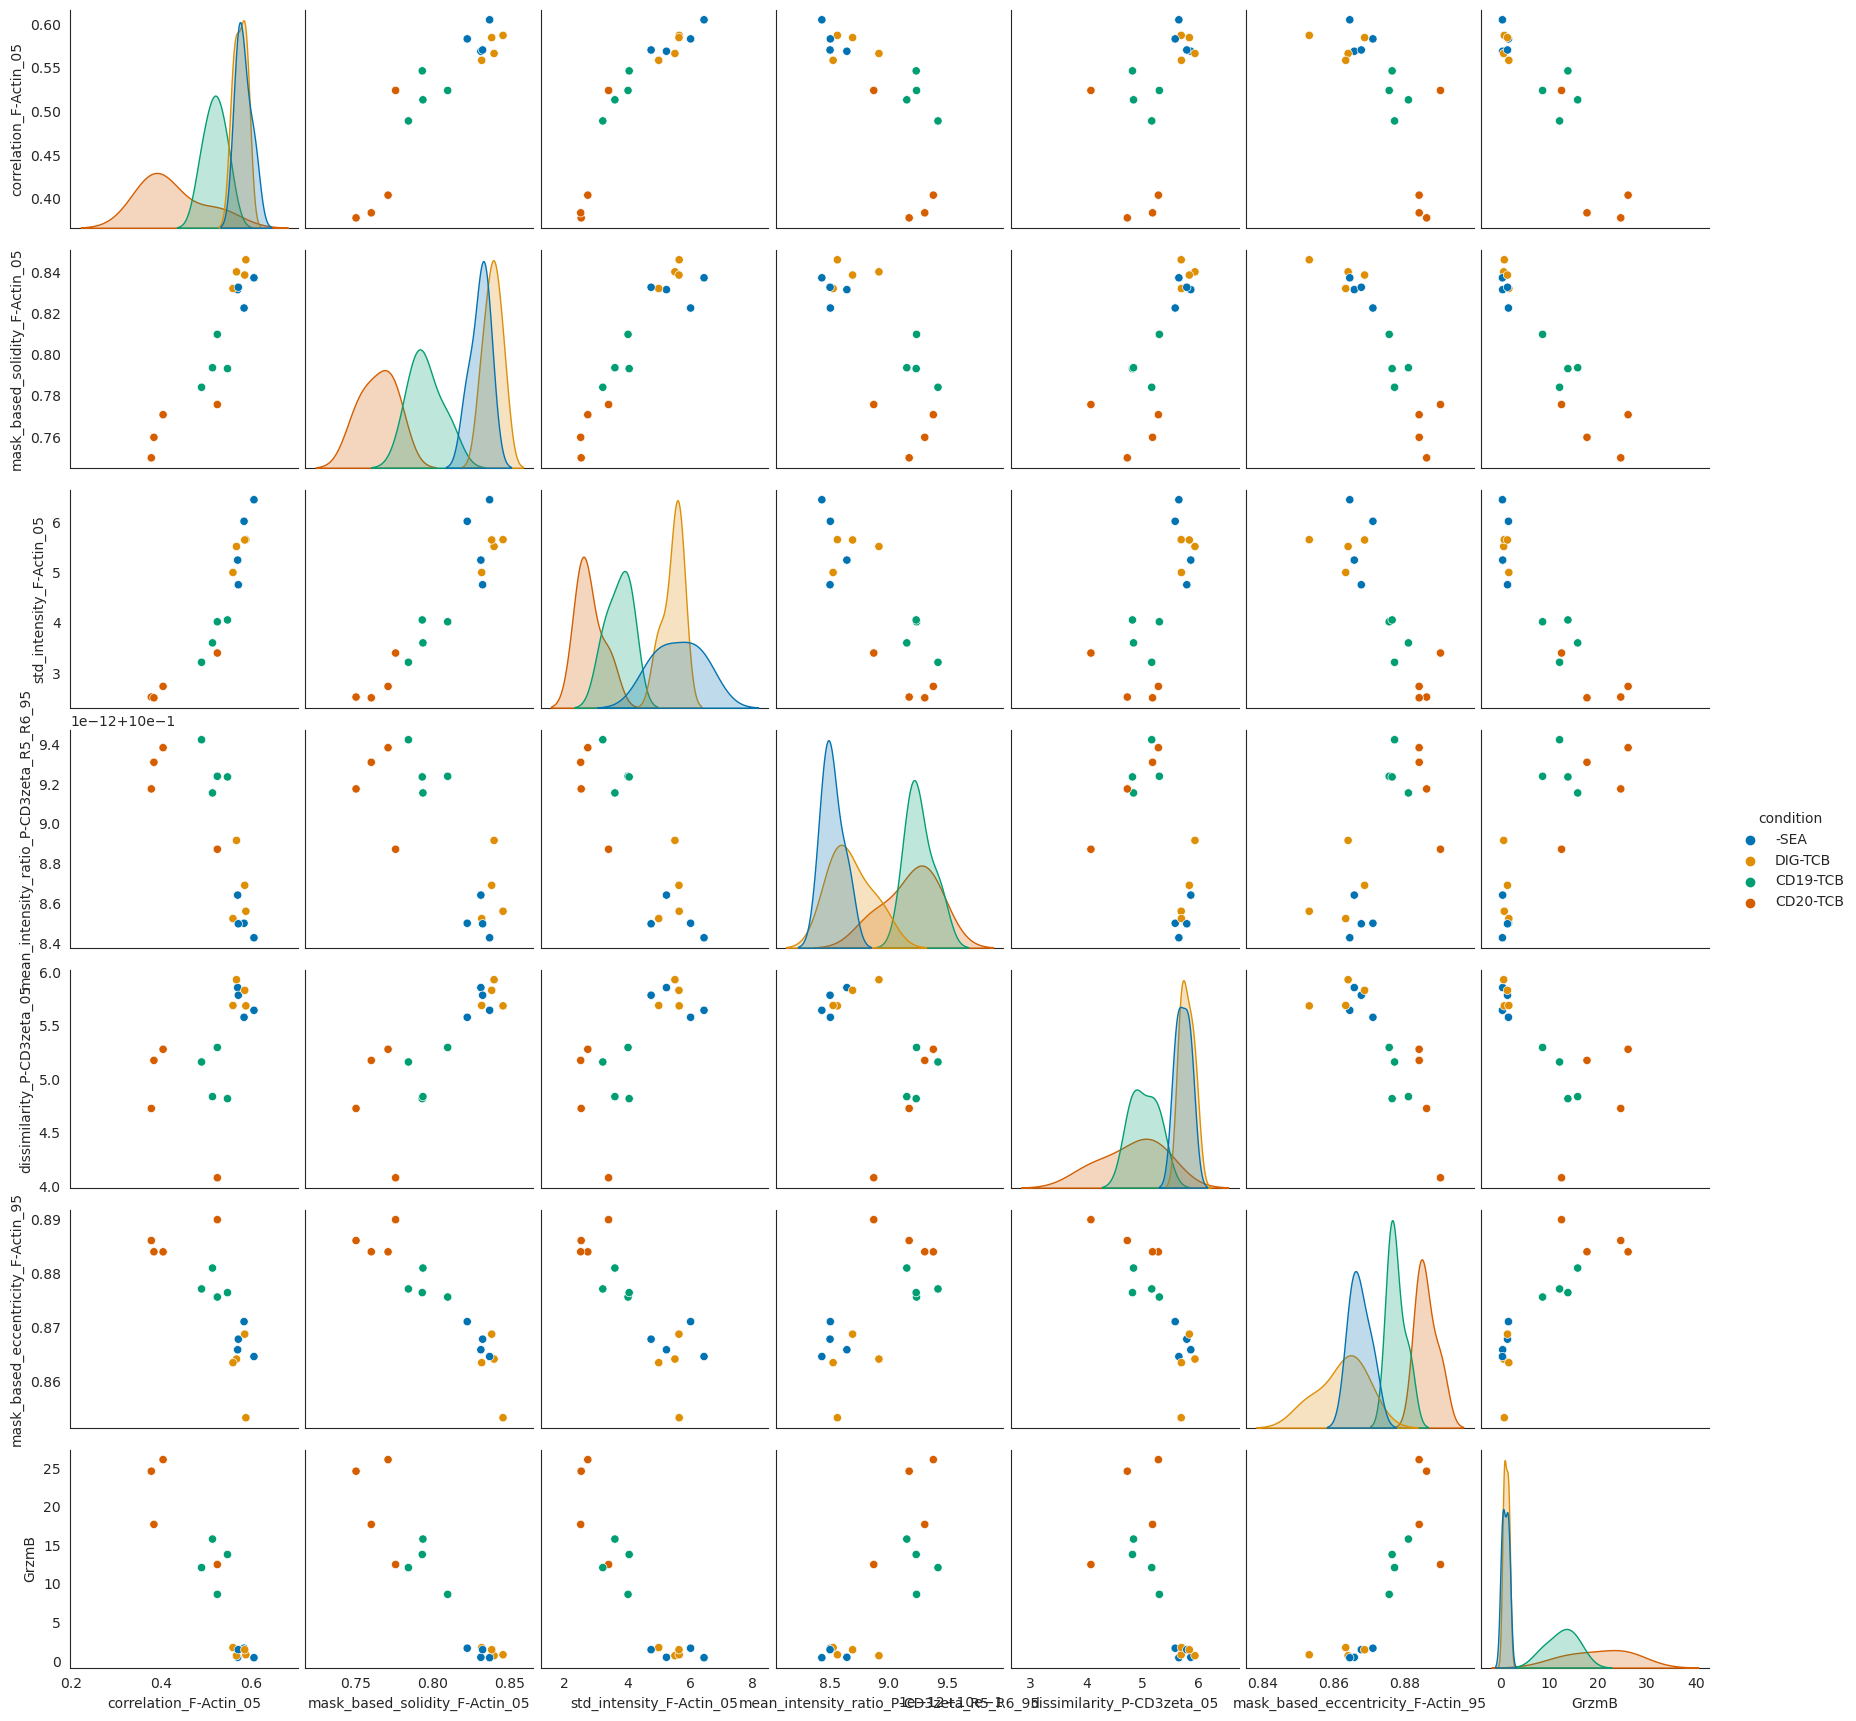

In [45]:
cols = ['correlation_F-Actin_05', 
'mask_based_solidity_F-Actin_05',
'std_intensity_F-Actin_05',
'mean_intensity_ratio_P-CD3zeta_R5_R6_95',
'dissimilarity_P-CD3zeta_05',
'mask_based_eccentricity_F-Actin_95',"condition","GrzmB" ]

row_index  = ["-SEA",'DIG-TCB', 'CD19-TCB','CD20-TCB']
    
row_index = metadata_alive["condition"].isin(row_index)
row_index = row_index & metadata_alive["experiment"].isin(["Experiment_4"])    


sns.pairplot(data = metadata_alive.loc[row_index,cols],
                     hue = "condition", 
                     hue_order = ["-SEA",'DIG-TCB', 'CD19-TCB','CD20-TCB'], 
                     palette = sns.color_palette("colorblind"))

In [46]:
cols 

['correlation_F-Actin_05',
 'mask_based_solidity_F-Actin_05',
 'std_intensity_F-Actin_05',
 'mean_intensity_ratio_P-CD3zeta_R5_R6_95',
 'dissimilarity_P-CD3zeta_05',
 'mask_based_eccentricity_F-Actin_95',
 'condition',
 'GrzmB']

In [47]:

metadata_alive.loc[row_index,['correlation_F-Actin_05',
 'mask_based_solidity_F-Actin_05',
 'std_intensity_F-Actin_05',
 'mean_intensity_ratio_P-CD3zeta_R5_R6_95',
 'dissimilarity_P-CD3zeta_05',
 'mask_based_eccentricity_F-Actin_95',
 'GrzmB']].corr("spearman").round(2)

correlation_F-Actin_05  \
correlation_F-Actin_05                                     1.00   
mask_based_solidity_F-Actin_05                             0.89   
std_intensity_F-Actin_05                                   0.96   
mean_intensity_ratio_P-CD3zeta_R5_R6_95                   -0.84   
dissimilarity_P-CD3zeta_05                                 0.66   
mask_based_eccentricity_F-Actin_95                        -0.79   
GrzmB                                                     -0.88   

                                         mask_based_solidity_F-Actin_05  \
correlation_F-Actin_05                                             0.89   
mask_based_solidity_F-Actin_05                                     1.00   
std_intensity_F-Actin_05                                           0.88   
mean_intensity_ratio_P-CD3zeta_R5_R6_95                           -0.69   
dissimilarity_P-CD3zeta_05                                         0.82   
mask_based_eccentricity_F-Actin_95                                -0.92   
GrzmB                                                             -0.89   

                                         std_intensity_F-Actin_05  \
correlation_F-Actin_05                                       0.96   
mask_based_solidity_F-Actin_05                               0.88   
std_intensity_F-Actin_05                                     1.00   
mean_intensity_ratio_P-CD3zeta_R5_R6_95                     -0.79   
dissimilarity_P-CD3zeta_05                                   0.67   
mask_based_eccentricity_F-Actin_95                          -0.82   
GrzmB                                                       -0.88   

                                         mean_intensity_ratio_P-CD3zeta_R5_R6_95  \
correlation_F-Actin_05                                                     -0.84   
mask_based_solidity_F-Actin_05                                             -0.69   
std_intensity_F-Actin_05                                                   -0.79   
mean_intensity_ratio_P-CD3zeta_R5_R6_95                                     1.00   
dissimilarity_P-CD3zeta_05                                                 -0.53   
mask_based_eccentricity_F-Actin_95                                          0.65   
GrzmB                                                                       0.72   

                                         dissimilarity_P-CD3zeta_05  \
correlation_F-Actin_05                                         0.66   
mask_based_solidity_F-Actin_05                                 0.82   
std_intensity_F-Actin_05                                       0.67   
mean_intensity_ratio_P-CD3zeta_R5_R6_95                       -0.53   
dissimilarity_P-CD3zeta_05                                     1.00   
mask_based_eccentricity_F-Actin_95                            -0.84   
GrzmB                                                         -0.79   

                                         mask_based_eccentricity_F-Actin_95  \
correlation_F-Actin_05                                                -0.79   
mask_based_solidity_F-Actin_05                                        -0.92   
std_intensity_F-Actin_05                                              -0.82   
mean_intensity_ratio_P-CD3zeta_R5_R6_95                                0.65   
dissimilarity_P-CD3zeta_05                                            -0.84   
mask_based_eccentricity_F-Actin_95                                     1.00   
GrzmB                                                                  0.84   

                                         GrzmB  
correlation_F-Actin_05                   -0.88  
mask_based_solidity_F-Actin_05           -0.89  
std_intensity_F-Actin_05                 -0.88  
mean_intensity_ratio_P-CD3zeta_R5_R6_95   0.72  
dissimilarity_P-CD3zeta_05               -0.79  
mask_based_eccentricity_F-Actin_95        0.84  
GrzmB                                     1.00

In [48]:
metadata.outlier.unique()

array([0])

## sample images

Now lets take a look at 5 randomly sampled images from CD19-TCB and CD20-TCB

[753.0, 38.0, 39.0] [986.5999999999985, 1893.7999999999993, 281.5400000000009]


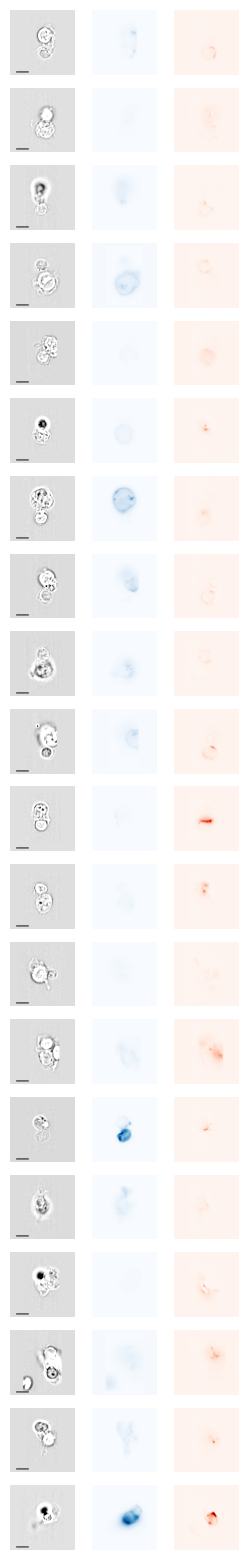

In [49]:

image_size = 128
channels_to_be_plotted = [0,4,6]
channel_colors = ["Greys","Blues","Reds"]

files = []
k = 10

cd19_indx = metadata.prediction == 'Synapses_with_signaling' 
cd19_indx = cd19_indx & (metadata.condition.astype(str) == 'CD19-TCB')
cd19_indx = cd19_indx & (metadata.experiment.astype(str) == 'Experiment_4')
cd19_indx = cd19_indx & (metadata.donor.astype(str) == 'Donor_2')
cd19_indx = cd19_indx[cd19_indx].sample(k,replace=False, random_state=0).index
cd19_files = metadata.loc[cd19_indx, "file"].sample(k,replace=False, random_state=0)
cd19_files = cd19_files.str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()


cd20_indx = metadata.prediction == 'Synapses_with_signaling' 
cd20_indx = cd20_indx & (metadata.condition.astype(str) == 'CD20-TCB')
cd20_indx = cd20_indx & (metadata.experiment.astype(str) == 'Experiment_4')
cd20_indx = cd20_indx & (metadata.donor.astype(str) == 'Donor_2')
cd20_indx = cd20_indx[cd20_indx].sample(k,replace=False, random_state=0).index
cd20_files = metadata.loc[cd20_indx, "file"].sample(k,replace=False, random_state=0)
cd20_files = cd20_files.str.replace("/pstore/data/DS4/","/projects/site/pred/data_science/year/2022/immunological_synapse/").tolist()


files = cd19_files + cd20_files
nrows = len(files)
ncols = len(channels_to_be_plotted)

fix,ax = plt.subplots(nrows, ncols, figsize = ( ncols*1, nrows*1 ))
    
vmin = [4095.]*ncols
vmax = [0.]*ncols

for i in range(nrows):
    h5_file_ = h5py.File(files[i], "r")
    image = h5_file_.get("image")[()]
    mask = h5_file_.get("mask")[()]
    for j, ch in enumerate(channels_to_be_plotted):
        if j>0:
            vmin[j] = min(vmin[j], np.quantile(image[:,:,ch], 0.50)  )
            vmax[j] = max(vmax[j], np.quantile(image[:,:,ch], 0.999)  )
        else:
            vmin[j] = min(vmin[j], np.quantile(image[:,:,ch], 0.10)  )
            vmax[j] = max(vmax[j], np.quantile(image[:,:,ch], 0.99)  )

        
print(vmin,vmax)
for i in range(nrows):
    h5_file_ = h5py.File(files[i], "r")
    image = h5_file_.get("image")[()]
    h, w = crop_pad_h_w(image, image_size)
    h1_crop, h2_crop, h1_pad, h2_pad =  h 
    w1_crop, w2_crop, w1_pad, w2_pad = w 
    for j, ch in enumerate(channels_to_be_plotted):
            image_dummy = crop(image[:,:,ch], ((h1_crop,h2_crop),(w1_crop,w2_crop)))
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values=np.median(image_dummy) )
            if j == 0:
                image_dummy[int(0.95*image_size):int(0.95*image_size+2), 
                            int(0.1*image_size):int(0.1*image_size  +25)] = vmax[j]
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].axis('off')
    h5_file_.close()

plt.savefig('Supplementary Figure - CD19 vs CD20 samples Donor 2.svg', bbox_inches="tight")

In [50]:

cols = [ "mean_intensity_MHCII", "std_intensity_MHCII", "mean_intensity_P-CD3zeta", 'mean_intensity_ratio_P-CD3zeta_R5_R6']

df_features.loc[cd19_indx, cols].quantile(0.95)

mean_intensity_MHCII                    310.644271
std_intensity_MHCII                     133.632444
mean_intensity_P-CD3zeta                 54.385145
mean_intensity_ratio_P-CD3zeta_R5_R6      0.933891
Name: 0.95, dtype: float64

In [51]:

cols = [ "mean_intensity_MHCII", "std_intensity_MHCII", "mean_intensity_P-CD3zeta", 'mean_intensity_ratio_P-CD3zeta_R5_R6']

df_features.loc[cd20_indx, cols].quantile(0.95)

mean_intensity_MHCII                    574.375578
std_intensity_MHCII                     453.247415
mean_intensity_P-CD3zeta                 72.636875
mean_intensity_ratio_P-CD3zeta_R5_R6      0.918030
Name: 0.95, dtype: float64